# **LIBRARIES**

In [1]:
import numpy as np
import tensorflow as tf
import urllib
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random

# **FUNCTION**

In [2]:
# Variables and Objects
IMAGE_SHAPE=100
batch_size=64
#
datagen = ImageDataGenerator(rescale=1/255.)

#----------------------
# get_inputShape()
# give the the shape adapted for the fit() operation
#----------------------
#
def get_inputShape(i_IMAGE_SHAPE,i_level=1):
  return (i_IMAGE_SHAPE, i_IMAGE_SHAPE, i_level)

#----------------------
#-- get_generator()
# give generator for train or validation data 
#----------------------
#
def get_generator(i_X_t,i_y_t,i_datagen,i_batch_size=batch_size):
  l_datagen_flow=i_datagen.flow(i_X_t, i_y_t, batch_size=i_batch_size, 
                            shuffle=True,seed=2, save_to_dir=None)
  return l_datagen_flow

#----------------------
# resize_array()
# give the array associated to resized image
#----------------------
#
def resize_array(i_array,i_img_shape_init=(112,92),i_img_shape_target=(IMAGE_SHAPE,IMAGE_SHAPE)):
  l_list=[]
  for i in range(len(i_array)):
    l_img=Image.fromarray(i_array[i].reshape(i_img_shape_init)) 
    l_img=l_img.resize(i_img_shape_target)
    #
    l_image_sequence = l_img.getdata()
    l_image_array = np.array(l_image_sequence)
    l_list.append(l_image_array)
    l_Ar=np.array(l_list)
    l_Ar=l_Ar.reshape(len(l_Ar),i_img_shape_target[0],i_img_shape_target[1])
  return l_Ar

#----------------------------
#--- plot_n_images()
#----------------------------
#
# plot n images (gray) randomly from X_train or X_test passed as a parameter
def plot_n_images(i_X,i_rows=2,i_cols=5):
  i_rows = 2
  i_cols = 5
  l_axes=[]
  l_newsize=(100,100)
  fig=plt.figure(figsize=(10,4))
  ll=[]
  for a in range(i_rows*i_cols):
      j=random.randint(0,len(i_X))
      l_axes.append( fig.add_subplot(i_rows, i_cols, a+1) )
      subplot_title=("Subplot"+str(a)+str('--->')+ str(y_train[j]))
      l_axes[-1].set_title(subplot_title)
      img=Image.fromarray(X_train[j].reshape(112,92)) 
      img=img.resize(l_newsize)
      ll.append(img) 
      plt.imshow(img,cmap=plt.get_cmap('gray'))
  fig.tight_layout()    
  plt.show()

#----------------------------
#--- Generate le CNN model
#----------------------------

def get_model(i_inputShape):
  l_model=Sequential()
  l_model.add(Input((i_inputShape)))
  l_model.add(Conv2D(128, kernel_size=(5,5),activation='relu'))
  l_model.add(MaxPooling2D(pool_size=(2,2)))
  l_model.add(Dense(128,activation='relu'))
  l_model.add(Flatten())
  #l_model.add(Dropout(0.4))
  l_model.add(Dense(20,activation='softmax'))

  #l_model.summary()
  
  return l_model

#-------------------------------------
#--- fit_model()
#-------------------------------------
#
def fit_model(i_model, i_train_generator, i_validation_generator, 
                  i_num_epoch,i_lr,i_verbose=0):
  l_model=i_model
  l_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=i_lr),
                metrics=['accuracy'])

  class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.90):
            print("\nReached 90% val_accuracy so cancelling training!")
            self.model.stop_training = True
  callbacks = myCallback()
#  validation_steps=8
  l_history= l_model.fit(
    i_train_generator,
    epochs=i_num_epoch, 
    validation_data = i_validation_generator,
    callbacks=[callbacks],
    verbose=i_verbose )
  return l_model, l_history

#----------------------------
#--- For loss and accuracy evaluating
#----------------------------
def eval(i_model,i_validation_generator):
  l_scores = i_model.evaluate(i_validation_generator,verbose=0)
  #print('loss=',np.round(l_scores[0]*100,2),'%')
  print('accuracy=',np.round(l_scores[1]*100,2),'%')

#----------------------------
#--- To plot loss and accuracy vs epochs
#----------------------------
def plot_loss_acc(i_history):

  acc = i_history.history['accuracy']
  loss = i_history.history['loss']
  #
  val_acc = i_history.history['val_accuracy']
  val_loss = i_history.history['val_loss']

  epochs = range(len(acc))
  
  plt.style.use('seaborn-whitegrid')
  #plt.figure(figsize=(6, 4))
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')
  plt.title('Training accuracy & Validation accuracy')
  plt.legend()
  #
  plt.figure()
  #plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training loss &  Validation loss')
  plt.legend()

#-----------------------------------------
#--- Used to Evaluate classification models
#-----------------------------------------
def fit_and_evaluate_model(i_model,i_X_train,i_X_test,i_y_train,i_y_test):
  #
  l_model=i_model
  l_model.fit(i_X_train, i_y_train)
  l_ypred = l_model.predict(i_X_test)

  print(confusion_matrix(i_y_test, l_ypred))
  print(classification_report(i_y_test, l_ypred))

  return l_model


# **TREATMENT**

In [3]:
data = np.load('/content/ORL_faces.npz')
data.files

['testY', 'testX', 'trainX', 'trainY']

In [4]:
data['trainX'].shape,data['trainY'].shape,data['testX'].shape,data['testY'].shape

((240, 10304), (240,), (160, 10304), (160,))

In [11]:
# Values of Target Data
print(list(set(data['trainY'])))
print(list(set(data['testY'])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Image from train data. Id face --> y_train[idx]= 0


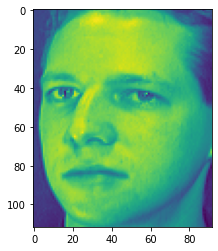

In [5]:
X_train=data['trainX']
y_train=data['trainY']
#
idx=10
print("Image from train data. Id face --> y_train[idx]=", y_train[idx])
plt.imshow(X_train[idx].reshape(112,92))

Image from test data. Id face -->  y_test[idx]= 2


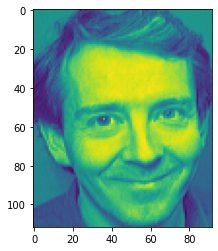

In [6]:
X_test=data['testX']
y_test=data['testY']
#
idx=20
print("Image from test data. Id face -->  y_test[idx]=", y_test[idx])
plt.imshow(X_test[idx].reshape(112,92))

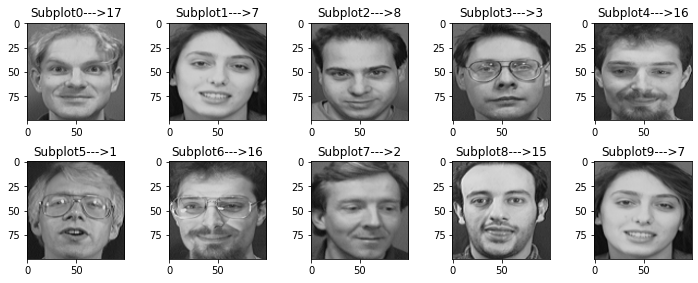

In [7]:
# 10 gray images from X_train --> Randomly
plot_n_images(X_train)

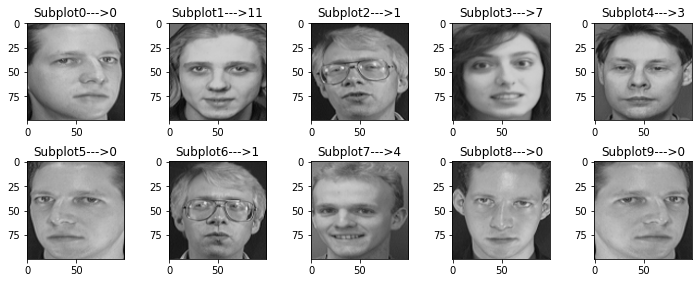

In [8]:
# 10 gray images from X_test --> Randomly
plot_n_images(X_test)

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 9.7443 - accuracy: 0.1125 - val_loss: 3.0699 - val_accuracy: 0.1375
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 3.0559 - accuracy: 0.1250 - val_loss: 2.6467 - val_accuracy: 0.2375
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 2.2588 - accuracy: 0.4500 - val_loss: 2.3572 - val_accuracy: 0.2625
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.8288 - accuracy: 0.4750 - val_loss: 1.6339 - val_accuracy: 0.6250
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 1.6571 - accuracy: 0.5292 - val_loss: 2.0184 - val_accuracy: 0.4688
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 1.0021 - accuracy: 0.7750 - val_loss: 1.0586 - val_accuracy: 0.7563
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.3548 - accuracy: 0.9292 - val_loss: 0.5702 - val_accuracy: 0.9000
Epoch 8/100
4/4 [=================

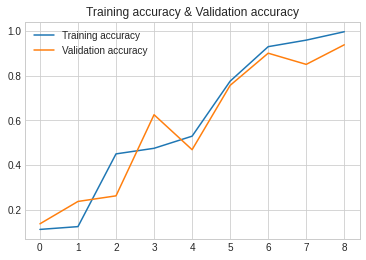

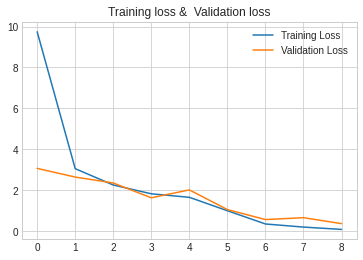

In [9]:
#-----------
epochs=100
#-----------
#
X_train_t=np.expand_dims(resize_array(X_train),axis=-1)
X_test_t=np.expand_dims(resize_array(X_test),axis=-1)
#
model_FacRecog,history_FacRecog=fit_model(get_model(get_inputShape(IMAGE_SHAPE)), 
                                    get_generator(X_train_t,y_train,datagen),
                                          get_generator(X_test_t,y_test,datagen),
                                                  epochs,i_lr=0.001, i_verbose=1)

plot_loss_acc(history_FacRecog)


#--- Evaluate on Validation data
#
print('\n\nAccuracy on the Evaluation Validation Data:')
print('--------')
eval(model_FacRecog,get_generator(X_test_t,y_test,datagen))
print('--------')

# TMP

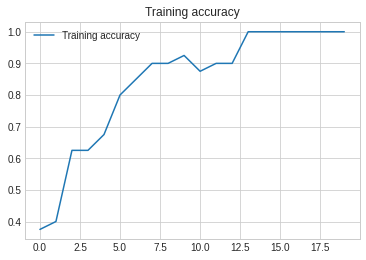

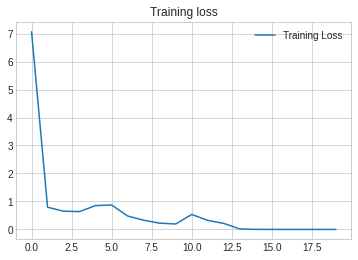

In [ ]:
#-----------
epochs=20
#-----------
#
model_20,history_20=fit_model(get_model(),epochs,0.001)

plot_loss_acc(history_20)

In [ ]:
#-------------------
# model_20: Evaluate on Validation data
#-------------------
print('loss and accuracy on the Evaluation Data:')
print('--------')
eval(model_20,validation_generator)
print('--------')


loss and accuracy on the Evaluation Data:
--------
loss= 297.2 %
accuracy= 50.0 %
--------


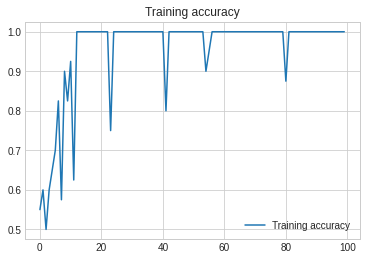

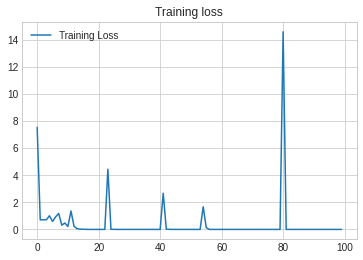

In [ ]:
#-----------
epochs=100
#-----------
#
model_100,history_100=fit_model(get_model(),epochs,0.001)

plot_loss_acc(history_100)

In [ ]:
#-------------------
# model_100: Evaluate on Validation data
#-------------------
print('loss and accuracy on the Evaluation Data:')
print('--------')
eval(model_100,validation_generator)
print('--------')

loss and accuracy on the Evaluation Data:
--------
loss= 576.29 %
accuracy= 60.0 %
--------


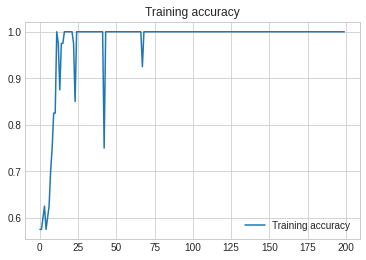

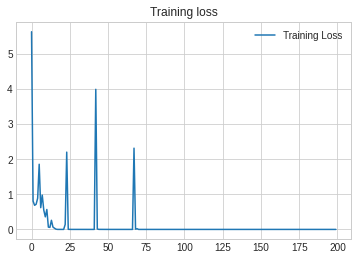

In [ ]:
#-----------
epochs=200
#-----------
#
model_200,history_200=fit_model(get_model(),epochs,0.001)

plot_loss_acc(history_200)

In [ ]:
#-------------------
# model_200: Evaluate on Validation data
#-------------------
print('loss and accuracy on the Evaluation Data:')
print('--------')
eval(model_200,validation_generator)
print('--------')

loss and accuracy on the Evaluation Data:
--------
loss= 1258.25 %
accuracy= 50.0 %
--------


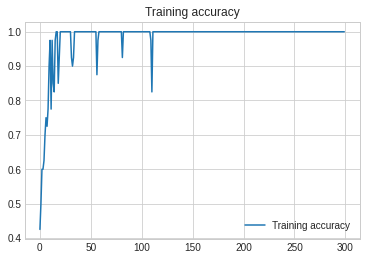

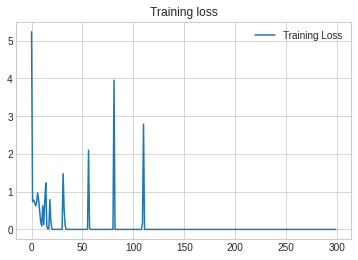

In [ ]:
#-----------
epochs=300
#-----------
#
model_300,history_300=fit_model(get_model(),epochs,0.001)

plot_loss_acc(history_300)

In [ ]:
#-------------------
# model_300: Evaluate on Validation data
#-------------------
print('loss and accuracy on the Evaluation Data:')
print('--------')
eval(model_300,validation_generator)
print('--------')

loss and accuracy on the Evaluation Data:
--------
loss= 1699.82 %
accuracy= 55.0 %
--------


# BONUS

In [ ]:

validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flowflow_from_directory(
                                      img_train_folder,  
                                      target_size=(300, 300),  
                                      batch_size=4,
                                      class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
                                      img_test_folder,  
                                      target_size=(300, 300), 
                                      batch_size=4,
                                      class_mode='binary')

inputShape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
fc_size=32

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
#
folder_dogs="dogs/"
folder_cats="cats/"
TFOLDER_PATH = "/content/content/pet_classification/data/test/"
#TFOLDER_PATH = "/content/content/pet_classification/data/train/"
IMAGE_SHAPE=300
#
tfolder_list_pet=[]
tfolder_list_pet_id=[]
tfolder_list_pet_id_pred=[]
#

#
tfolder_dogs_images = os.listdir(TFOLDER_PATH + os.sep+ folder_dogs)
tfolder_cats_images = os.listdir(TFOLDER_PATH + os.sep+ folder_cats)
# 
for i in range(len(tfolder_dogs_images)):
  #tfolder_list_pet.append(tfolder_dogs_images[i])
  tfolder_list_pet_id.append(0)  # dog --> 0
for i in range(len(tfolder_cats_images)):
  #tfolder_list_pet.append(tfolder_cats_images[i])
  tfolder_list_pet_id.append(1)  # cat --> 1
#

def get_prediction_list(i_model,i_folder,i_len,i_IMAGE_SHAPE=300):
  #
  l_tfolder_list_pet_id_pred=[]
  #
  for i in range(0,i_len):
    tfolder_pet_img = tfolder_dogs_images[i]
    tfolder_pet_img = cv2.imread(TFOLDER_PATH + os.sep+ i_folder + tfolder_pet_img)

    #plt.figure()
    #plt.imshow(tfolder_pet_img)

    tfolder_pet_img = cv2.resize(tfolder_pet_img / 255, (i_IMAGE_SHAPE, i_IMAGE_SHAPE))
    tfolder_pet_img = tfolder_pet_img.reshape(1, i_IMAGE_SHAPE, i_IMAGE_SHAPE, 3)

    prediction = i_model.predict(tfolder_pet_img)

    if prediction[0][0] <= 0.50:
        l_tfolder_list_pet_id_pred.append(1)
    else:
        l_tfolder_list_pet_id_pred.append(0)
  return l_tfolder_list_pet_id_pred

#
def print_report(i_model):
  ll_pred_dogs=get_prediction_list(i_model,"dogs/",len(tfolder_dogs_images))
  ll_pred_cats=get_prediction_list(i_model,"cats/",len(tfolder_cats_images))
  #
  tfolder_list_pet_id_pred= ll_pred_dogs + ll_pred_cats
  #
  print('tfolder_list_pet_id--->')
  print('tfolder_list_pet_id_pred--->')
  print(tfolder_list_pet_id)
  print(tfolder_list_pet_id_pred)
  #
  print(confusion_matrix(tfolder_list_pet_id, tfolder_list_pet_id_pred))
  c_report= classification_report(tfolder_list_pet_id, tfolder_list_pet_id_pred)
  print(c_report)


In [ ]:
# Evaluate on Validation data
eval(model_20,validation_generator)
print()
print_report(model_20)

loss= 229.28 %
accuracy= 55.0 %

tfolder_list_pet_id--->
tfolder_list_pet_id_pred--->
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[4 6]
 [1 9]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.60      0.90      0.72        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20



[[0.07658239 0.92341757]]
Prediction--> pet_chien01.jpg   It's a CAT ... 

[[0.81738275 0.18261719]]
Prediction--> petchien02.jpg   It's a DOG ==== 

[[0.45449582 0.5455042 ]]
Prediction--> chat_01.jpg   It's a CAT ... 



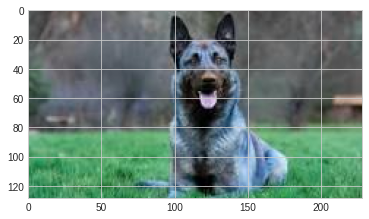

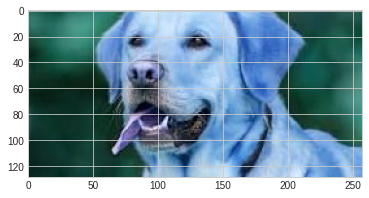

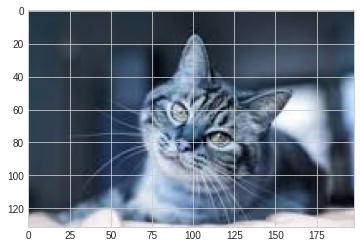

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
#
#-------------------------
model=model_20
#--------------------------

IMAGE_SHAPE=300
#-------------------
TEST_PATH = "/content/content/pet_classification/data/test/"
TEST_PATH = "/content/tmp/"
folder_pets="dogs/"
folder_pets="dogs/"
folder_pets="petss/"
#-----------------------
test_pets_images = os.listdir(TEST_PATH + os.sep+ folder_pets)

for i in range(0,len(test_pets_images)):
  n_image=test_pets_images[i]
  test_pet_img = test_pets_images[i]
  test_pet_img = cv2.imread(TEST_PATH + os.sep+ folder_pets + test_pet_img)

  plt.figure()
  plt.imshow(test_pet_img)

  test_pet_img = cv2.resize(test_pet_img / 255, (IMAGE_SHAPE, IMAGE_SHAPE))
  test_pet_img = test_pet_img.reshape(1, IMAGE_SHAPE, IMAGE_SHAPE, 3)

  prediction = model.predict(test_pet_img)

  print(prediction)

  if prediction[0][0] <= 0.5:
      print("Prediction-->", n_image,"  It's a CAT ...",'\n')
  else:
      print("Prediction-->", n_image,"  It's a DOG ====",'\n')

In [ ]:
print(len(test_pets_images))

2
